In [1]:
import fitparse as Fit
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
ride = Fit.FitFile('Rides/NCAR.fit')

In [3]:
laps = []
for lap in ride.get_messages('lap'):
    laps.append({
        'start_time': lap.get_value('timestamp'),
        'elapsed_time': lap.get_value('total_elapsed_time')
    })
print(laps)

[{'start_time': datetime.datetime(2020, 8, 7, 17, 35, 36), 'elapsed_time': 910.0}, {'start_time': datetime.datetime(2020, 8, 7, 17, 41, 44), 'elapsed_time': 368.0}, {'start_time': datetime.datetime(2020, 8, 7, 18, 54, 31), 'elapsed_time': 4367.0}]


In [4]:
records = []
for record in ride.get_messages('record'):
    records.append({
        'timestamp': record.get_value('timestamp'),
        'lat': record.get_value('position_lat'),
        'lon': record.get_value('position_long'),
        'speed': record.get_value('speed'),
        'altitude': record.get_value('altitude'),
        'grade': record.get_value('grade'),
        'heartrate': record.get_value('heart_rate'),
        'cadence': record.get_value('cadence'),
        'power': record.get_value('power'),
    })

In [5]:
def getAxis(ls, axis):
    return [x[axis] for x in ls]

def binValues(ls, key, bins):
    hist = {}
    for i in range(len(bins) + 1):
        hist[i] = []
    for x in ls:
        for i in range(len(bins)):
            if x[key] < bins[i]:
                hist[i+1].append(x)
                break
    return hist

def plotMap(records):
    x = getAxis(records, 'lon')
    y = getAxis(records, 'lat')
    plt.scatter(x,y)
    plt.axis('equal')
    plt.title('Map')
    
def plotAttr(records, attr, x_axis='timestamp', c='C0'):
    x = getAxis(records, x_axis)
    y = getAxis(records, attr)
    plt.plot(x,y, c=c)
    label = plt.ylabel(attr.capitalize())
    label.set_color(c)

In [6]:
lap_records = binValues(records, 'timestamp', getAxis(laps, 'start_time'))
for x in lap_records:
    print(x, len(lap_records[x]))

0 0
1 907
2 368
3 3969


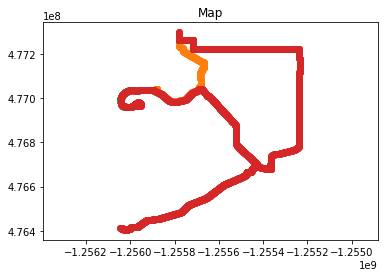

In [7]:
for lap_num in lap_records:
    plotMap(lap_records[lap_num])

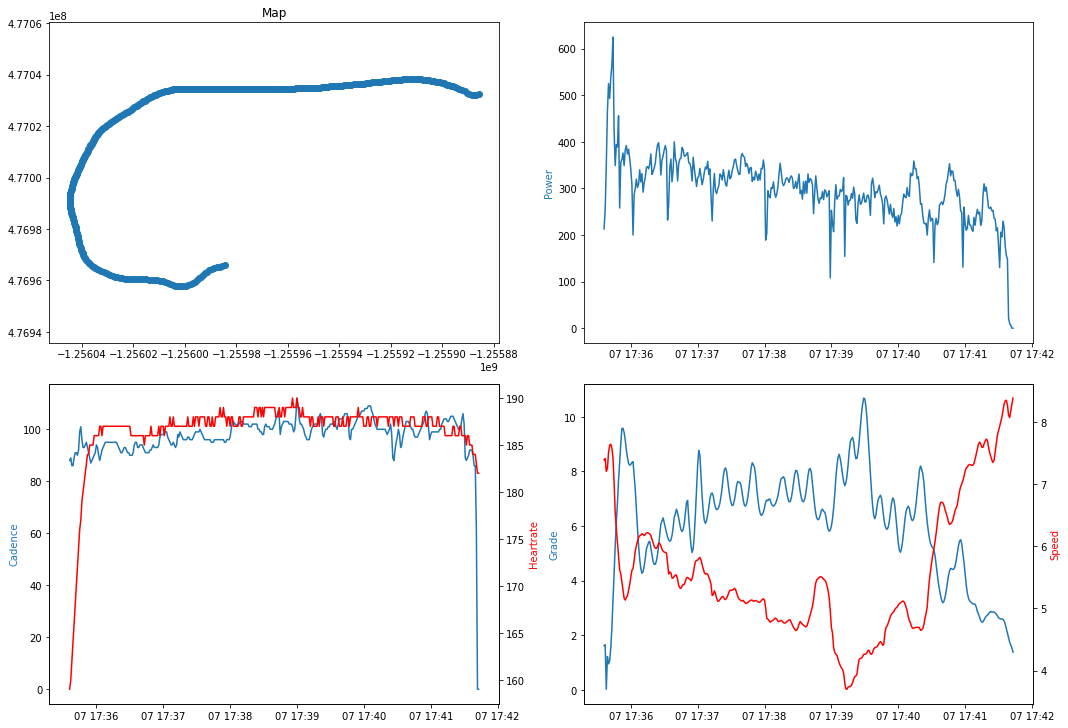

In [8]:
segment = lap_records[2]
plt.figure(figsize=(15,15))
sub_x, sub_y = 3,2
plt.subplot(sub_x,sub_y,1)
plotMap(segment)

plt.subplot(sub_x,sub_y,2)
plotAttr(segment, 'power')

plt.subplot(sub_x,sub_y,3)
plotAttr(segment, 'cadence')
plt.twinx()
plotAttr(segment, 'heartrate', c='r')


plt.subplot(sub_x,sub_y,4)
plotAttr(segment, 'grade')
plt.twinx()
plotAttr(segment, 'speed', c='r')

plt.tight_layout()

In [9]:
energy = []
mass = 66 + 8
for record in segment:
    e = {
        'gravitational': mass * 9.8 * record['altitude'],
        'kinetic': 0.5 * mass * record['speed'] ** 2,
        'air friction': record['speed'] ** 3, # missing proper coefficient of drag
        'rolling friction': record['speed'], # missing coefficient of rolling resistance
        'timestamp': record['timestamp'],
    }
    e['total'] = e['gravitational'] + e['kinetic'] + e['air friction'] + e['rolling friction']
    energy.append(e)

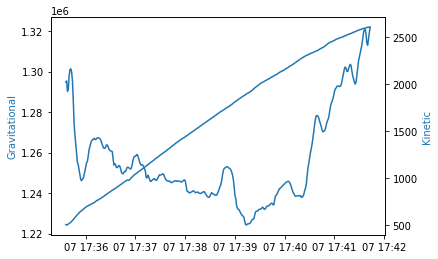

In [10]:
plotAttr(energy, 'gravitational')
plt.twinx()
plotAttr(energy, 'kinetic')

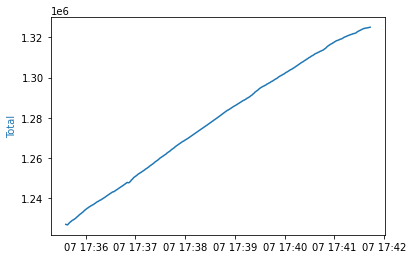

In [11]:
plotAttr(energy, 'total')

In [12]:
pad = 10
power = []
for i in range(pad, len(energy) - pad):
    power.append({
        'timestamp': energy[i]['timestamp'],
        'power': (energy[i+1]['total'] - energy[i-1]['total']) / 2,
    })

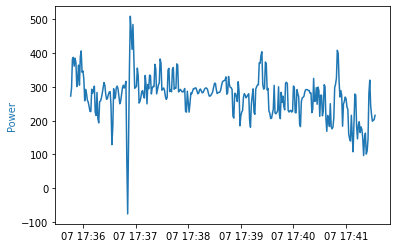

In [13]:
# Still missing proper coefficients of friction in force calculations. Still, initial results aren't bad.
plotAttr(power, 'power')

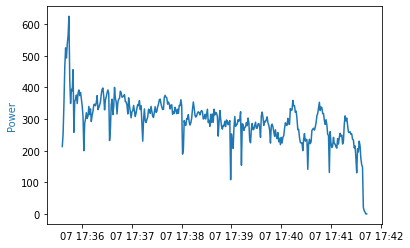

In [14]:
plotAttr(segment, 'power')

In [16]:
np.mean(getAxis(power, 'power'))

272.64222667406574

In [17]:
np.mean(getAxis(segment, 'power'))

297.3858695652174